In [16]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [18]:
# Create train and validation datasets
path = '/content/drive/MyDrive/Colab Notebooks/hector/3 categories'
image_size=(180, 150)
batch_size=32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="training",
  seed=1337,
  image_size=image_size,
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="validation",
  seed=1337,
  image_size=image_size,
  batch_size=batch_size)

Found 5182 files belonging to 3 classes.
Using 4146 files for training.
Found 5182 files belonging to 3 classes.
Using 1036 files for validation.


In [19]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    previous_block_activation = x  # Set aside residual
    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)
# For 3 classes
model_3_classes = make_model(input_shape=image_size + (3,), num_classes=3)

In [20]:
from sklearn.utils import class_weight
# Extract the labels from training data
train_labels = []
for images, labels in train_ds:
    train_labels.extend(labels.numpy().tolist())

In [34]:
# Compute class weights
y = train_labels
from sklearn.utils import class_weight
class_weights=class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y),y=y)
# Convert the class weights from an array to a dictionary
class_weights = dict(enumerate(class_weights))

In [35]:
epochs = 10
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model_3_classes.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
history = model_3_classes.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
    class_weight=class_weights
)


Epoch 1/10
130/130 [==============================] - 45s 283ms/step - loss: 0.0052 - accuracy: 0.9983 - val_loss: 1.4081 - val_accuracy: 0.3736
Epoch 2/10
130/130 [==============================] - 39s 299ms/step - loss: 0.0011 - accuracy: 0.9993 - val_loss: 1.1700 - val_accuracy: 0.5512
Epoch 3/10
130/130 [==============================] - 36s 277ms/step - loss: 3.1017e-04 - accuracy: 0.9998 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 4/10
130/130 [==============================] - 37s 281ms/step - loss: 4.6429e-05 - accuracy: 1.0000 - val_loss: 8.2192e-06 - val_accuracy: 1.0000
Epoch 5/10
130/130 [==============================] - 37s 280ms/step - loss: 2.4059e-06 - accuracy: 1.0000 - val_loss: 3.0837e-07 - val_accuracy: 1.0000
Epoch 6/10
130/130 [==============================] - 39s 296ms/step - loss: 2.4914e-06 - accuracy: 1.0000 - val_loss: 1.0482e-07 - val_accuracy: 1.0000
Epoch 7/10
130/130 [==============================] - 37s 278ms/step - loss: 3.2964e-06 - accuracy: 1.

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [37]:
y_true = []
y_pred = []
for x_batch, y_batch in val_ds:
    y_pred_batch = model_3_classes.predict(x_batch)
    y_pred_batch = np.argmax(y_pred_batch, axis=1)
    y_pred.extend(y_pred_batch)
    y_true.extend(y_batch.numpy())

1/1 [==============================] - 0s 230ms/step


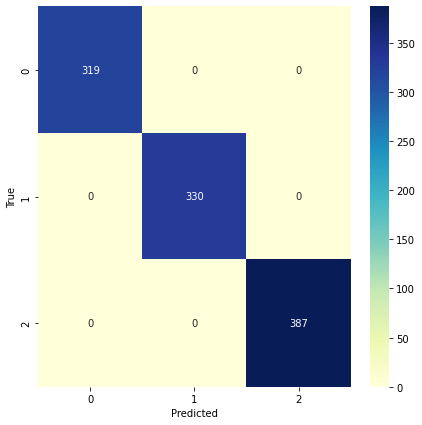

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [39]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)

Precision:  1.0
Recall:  1.0
F1 Score:  1.0


In [40]:
img = keras.preprocessing.image.load_img('/content/drive/MyDrive/Colab Notebooks/hector/3 categories/Major/PB01-1-01-02-N-02.jpg', target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
# Reshape the image so it has the same shape as the input to the model
img_array = img_array.reshape(1, *img_array.shape)
# Normalize the image by dividing by 255
img_array = img_array / 255.0
predictions = model_3_classes.predict(img_array)
# Get the class with the highest probability
predicted_class = np.argmax(predictions)
# Get the class labels from the train_ds
class_labels = train_ds.class_names
# Map the class label to the predicted class
predicted_category = class_labels[predicted_class]

print(f"The image belongs to the class: {predicted_class} ({predicted_category})")

1/1 [==============================] - 0s 22ms/step
The image belongs to the class: 2 (Minor)
